# Bayesian Hurdle Model (PyMC)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

## Basic Hurdle Gamma

The hurdle model written as a two-part mixture:

**Joint Distribution**

$$
f\left(y_i\right)= \begin{cases}1-\pi_i & \text { if } y_i=0 \\ \pi_i \cdot f_{\mathrm{pos}}\left(y_i \mid y_i>0\right) & \text { if } y_i>0\end{cases}
$$


Or the equivalent **likelihood formulation**

$$
L\left(y_i \mid \boldsymbol{\theta}\right)=\left(1-\pi_i\right)^{1\left(y_i=0\right)} \cdot\left[\pi_i \cdot f_{\mathrm{pos}}\left(y_i\right)\right]^{1\left(y_i>0\right)}
$$


...


$$
\begin{aligned}
\operatorname{Logit}\left(\pi_i\right) & =\mathbf{X}_{\mathrm{occur}, i}^T \boldsymbol{\beta}_{\mathrm{occur}} \\
Y_i \mid Y_i>0 & \sim \operatorname{Gamma}\left(\alpha, \beta_i\right) \quad \text { where } \beta_i=\alpha / e^{\mathbf{X}_{\mathrm{sev}, i}^T \beta_{\mathrm{sev}}}
\end{aligned}
$$

**Model Specification**

For observations $i=1, \ldots, n$ :

**Occurrence Model (Bernoulli/Logistic Regression)**

Claim indicator: 

$$
\quad C_i \sim \operatorname{Bernoulli}\left(\pi_i\right)
$$

Logit link: 

$$
\operatorname{logit}\left(\pi_i\right)=\mathbf{X}_{\text{occur}, i}^T \boldsymbol{\beta}_{\text{occur}}
$$

Or equivalently: 

$$
\quad \pi_i=\frac{1}{1+e^{-\mathbf{X}_{\text{occur}, i}^T \beta_{\text{occur}}}}
$$

**Severity Model (Gamma Regression, conditional on $C_i=1$ )**

$$
Y_i \mid C_i=1 \sim \operatorname{Gamma}\left(\alpha, \beta_i\right)
$$

Log link: 

$$
\quad \log \left(\mu_i\right)=\mathbf{X}_{\text {sev }, i}^T \boldsymbol{\beta}_{\text {sev }}
$$

Mean-rate relationship: 

$$
\quad \beta_i=\frac{\alpha}{\mu_i}
$$

Where:
$$
- \mathbb{E}\left[Y_i \mid C_i=1\right]=\mu_i=\frac{\alpha}{\beta_i} \\
- \operatorname{Var}\left[Y_i \mid C_i=1\right]=\frac{\alpha}{\beta_i^2}=\frac{\mu_i^2}{\alpha}
$$
**Complete Data Likelihood**

$$
Y_i= \begin{cases}0 & \text { with probability } 1-\pi_i \\ \operatorname{Gamma}\left(\alpha, \alpha / \mu_i\right) & \text { with probability } \pi_i\end{cases}
$$

**Prior Distributions**

$$
\begin{aligned}
\boldsymbol{\beta}_{\text {occur }} & \sim \operatorname{Normal}\left(\mathbf{0}, 1.5^2 \mathbf{I}_{p_1}\right) \\
\boldsymbol{\beta}_{\text {sev }} & \sim \operatorname{Normal}\left(\mathbf{0}, 1^2 \mathbf{I}_{p_2}\right) \\
\alpha & \sim \operatorname{Half-} \operatorname{Normal}\left(0,5^2\right)
\end{aligned}
$$

**Marginal Mean**

$$
\mathbb{E}\left[Y_i\right]=\pi_i \cdot \mu_i=\pi_i \cdot e^{\mathbf{X}_{\mathrm{sev}, i}^T \boldsymbol{\beta}_{\mathrm{sev}}}
$$

**Coefficient of Variation**

$$
C V=\frac{\sqrt{\operatorname{Var}\left[Y_i \mid C_i=1\right]}}{\mathbb{E}\left[Y_i \mid C_i=1\right]}=\frac{1}{\sqrt{\alpha}}
$$

In [2]:
def build_hurdle_gamma_model(X_occ, X_sev, Y_obs, claim_ind):
    """
    Build a simple Bayesian Hurdle Gamma Model using PyMC.

    Parameters:
    -----------
    X_occ : array (n, p1)
        Covariates for the occurrence model.
    X_sev : array (n, p2)
        Covariates for the severity model.
    Y_obs : array (n,)
        Observed response variable (claim amounts 0 for no claims, >0 for claim).
    claim_ind : array (n,)
        Indicator array where 1 indicates a claim occurred, 0 otherwise.

    Returns:
    ----------
    model : pm.Model
        The constructed PyMC model.
    """

    p1 = X_occ.shape[1]
    p2 = X_sev.shape[1]

    # Separate postive observations
    mask_positive = claim_ind == 1
    Y_pos = Y_obs[mask_positive]
    X_sev_pos = X_sev[mask_positive]

    with pm.Model() as model:
        # ==========================================
        # OCCURRENCE MODEL (all observations)
        # ==========================================

        # Priors for occurrence
        beta_occ = pm.Normal("beta_occ", mu=0, sigma=1.5, shape=p1)

        # Occurrence linear predictor
        logit_pi = pm.Deterministic("logit_pi", pm.math.dot(X_occ, beta_occ))
        pi = pm.Deterministic("pi", pm.math.sigmoid(logit_pi))

        # Likelihood for occurrence (all observations)
        claim = pm.Bernoulli("claim", p=pi, observed=claim_ind)

        # ==========================================
        # SEVERITY MODEL (only positive observations)
        # ==========================================

        # Priors for severity
        beta_sev = pm.Normal("beta_sev", mu=0, sigma=1, shape=p2)
        alpha = pm.HalfNormal("alpha", sigma=5)

        # Severity linear predictor (for positive claims)
        log_mu_sev = pm.math.dot(X_sev_pos, beta_sev)
        mu_sev = pm.Deterministic("mu_sev", pm.math.exp(log_mu_sev))

        # Gamma rate parameter: E[Y|claim] = alpha/beta, so beta = alpha/mu_sev
        beta_gamma = alpha / mu_sev

        # Likelihood for severity (only positive claims)
        Y_severity = pm.Gamma("Y_severity", alpha=alpha, beta=beta_gamma, observed=Y_pos)

        # ==========================================
        # POSTERIOR PREDICTIVE QUANTITIES
        # ==========================================

        # Marginal mean for all observations
        mu_marginal = pm.Deterministic("mu_marginal", pi * pm.math.exp(pm.math.dot(X_sev, beta_sev)))

        # Coefficient of variation for severity
        cv_severity = pm.Deterministic("cv_severity", 1.0 / pm.math.sqrt(alpha))

    return model

In [ ]:
def build_hurdle_gamma_builtin(X_occurrence, X_severity, Y_obs):
    """
    Hurdle-Gamma model - BUILT-IN approach using pm.HurdleGamma.
    
    Parameters:
    -----------
    X_occurrence : array (n, p1)
        Covariates for occurrence model
    X_severity : array (n, p2)
        Covariates for severity model
    Y_obs : array (n,)
        Observed outcomes (0 for no claim, >0 for claim amounts)
        
    Returns:
    --------
    PyMC model object
    
    Notes:
    ------
    - No need for claim_indicator with HurdleGamma
    - Automatically handles zeros vs positives
    - Pass ALL observations (including zeros) to likelihood
    """
    n = len(Y_obs)
    p1 = X_occurrence.shape[1]
    p2 = X_severity.shape[1]
    
    with pm.Model() as model:
        # ==========================================
        # OCCURRENCE MODEL
        # ==========================================
        beta_occur = pm.Normal('beta_occur', mu=0, sigma=1.5, shape=p1)
        
        # Occurrence probability (psi in HurdleGamma terminology)
        logit_pi = pm.Deterministic('logit_pi',
                                     pm.math.dot(X_occurrence, beta_occur))
        psi = pm.Deterministic('psi', pm.math.sigmoid(logit_pi))
        
        # ==========================================
        # SEVERITY MODEL
        # ==========================================
        beta_sev = pm.Normal('beta_sev', mu=0, sigma=1, shape=p2)
        alpha = pm.HalfNormal('alpha', sigma=5)
        
        # Severity mean (for ALL observations, not just positive)
        log_mu_sev = pm.math.dot(X_severity, beta_sev)
        mu_sev = pm.Deterministic('mu_sev', pm.math.exp(log_mu_sev))
        
        # ==========================================
        # HURDLE-GAMMA LIKELIHOOD
        # ==========================================
        # Single likelihood handles both zeros and positives
        # psi = P(Y > 0) - occurrence probability
        # alpha, beta = Gamma parameters for positive values
        beta_gamma = alpha / mu_sev
        pm.HurdleGamma('Y', 
                       psi=psi,           # Occurrence probability
                       alpha=alpha,       # Gamma shape (scalar)
                       beta=beta_gamma,   # Gamma rate (vector, one per obs)
                       observed=Y_obs)    # ALL observations (zeros + positives)
        
        # ==========================================
        # DERIVED QUANTITIES
        # ==========================================
        # Marginal mean: E[Y] = P(Y>0) × E[Y|Y>0] = psi × mu_sev
        mu_marginal = pm.Deterministic('mu_marginal', psi * mu_sev)
        
        # Coefficient of variation for severity component
        cv_severity = pm.Deterministic('cv_severity', 1.0 / pm.math.sqrt(alpha))
        
    return model

Simulate data and example usage.

In [3]:
np.random.seed(999)
n = 1000

# Covariates
X_occur = np.column_stack(
    [
        np.ones(n),
        np.random.normal(0, 1, n), # Some continuous covariate
        np.random.binomial(1, 0.3, n), # Some binary covariate (high risk region)
    ]
)

X_sev = np.column_stack(
    [
        np.ones(n),
        np.random.uniform(50, 150, n),
        np.random.gamma(2, 1, n)
    ]
)

# True parameters
beta_occur_true = np.array([-1.0, 0.5, 0.8])
beta_sev_true = np.array([2.0, 0.01, 0.3])
alpha_true = 4.0

# Generate data

logit_pi = X_occur @ beta_occur_true
pi = 1 / (1 + np.exp(-logit_pi))
claim_indicator = np.random.binomial(1, pi, n)

mu_sev = np.exp(X_sev @ beta_sev_true)
beta_gamma = alpha_true / mu_sev
Y_positive = np.random.gamma(alpha_true, 1 / beta_gamma[claim_indicator == 1])

Y_obs = np.zeros(n)
Y_obs[claim_indicator == 1] = Y_positive

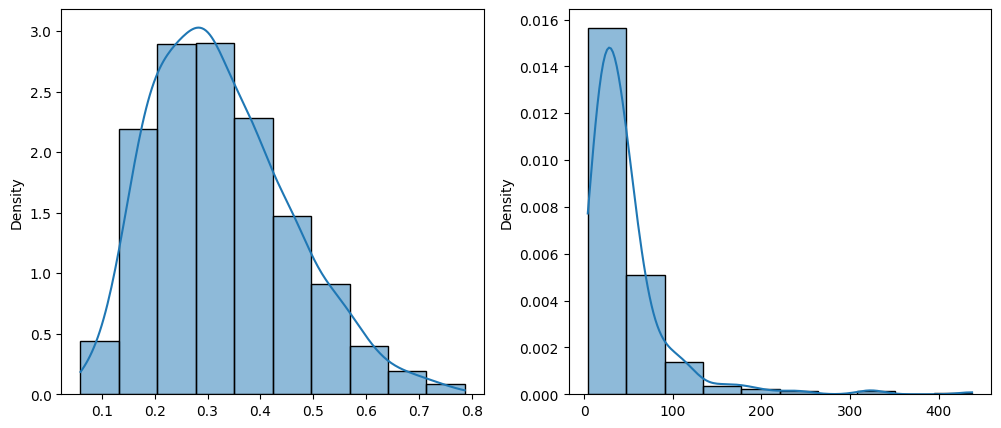

In [4]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(pi, bins=10, stat='density', kde=True, ax=ax[0])
sns.histplot(Y_positive, bins=10, stat='density', kde=True, ax=ax[1]);

In [5]:
model = build_hurdle_gamma_model(X_occur, X_sev, Y_obs, claim_indicator)

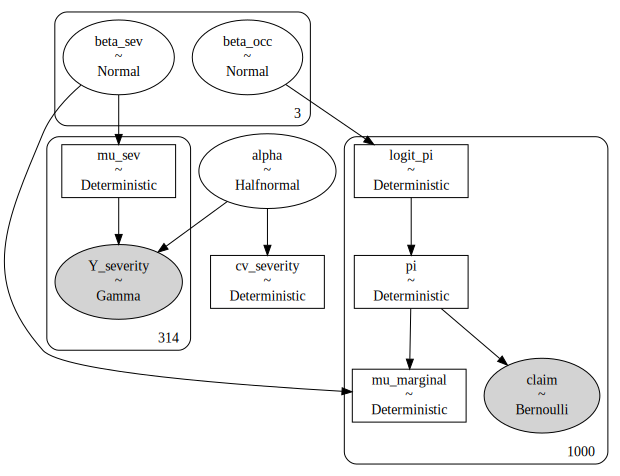

In [6]:
graph = pm.model_to_graphviz(model)
graph

- There are NO shared parameters between the two likelihoods.
- The two parts are connected only through the _deterministic_ calculation of `mu_marginal`.
- This means that we can factorize the posterior completely:

$$
p\left(\beta_{\mathrm{occ}}, \beta_{\mathrm{sev}}, \alpha \mid \text { data }\right)=p\left(\beta_{\mathrm{occ}} \mid C\right) \cdot p\left(\beta_{\mathrm{sev}}, \alpha \mid Y_{\text {positive }}\right)
$$

- You could estimate these two models separately and get identical results.
- A truly joint model would have shared parameters or hierarchical structures linking the two parts.
    - Shared parameters across both parts
    - Shared random effects
    - Correlation between occurrence and severity components (copula models)

In [ ]:
with model:
    trace = pm.sample(2000, tune=1000, cores=4, target_accept=0.95)

In [ ]:
print(pm.summary(trace, var_names=["beta_occ", "beta_sev", "alpha"]))

## Hierarchical Hurdle Models

### Random Intercept Only

Add a region where each region has a random effect that influences **both** occurrence probability and severity.  This creates a coupling between the two parts of the model.

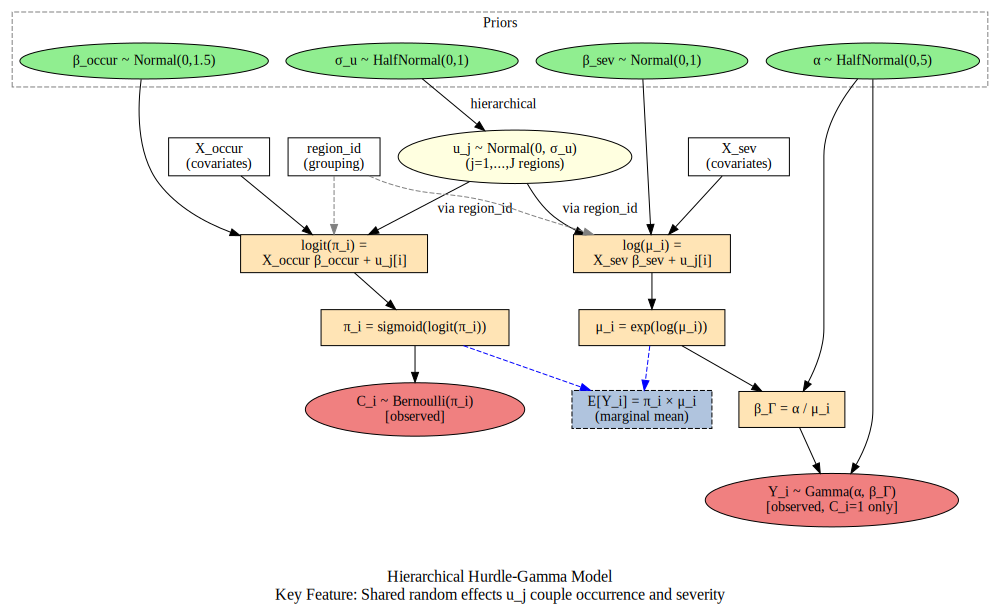

In [58]:
import graphviz

def create_hierarchical_hurdle_dag():
    """
    Create DAG for hierarchical hurdle-Gamma model with shared random effects.
    """
    dot = graphviz.Digraph(comment='Hierarchical Hurdle-Gamma Model')
    dot.attr(rankdir='TB')  # Top to bottom
    dot.attr('node', shape='ellipse', style='filled', fillcolor='lightblue')
    
    # Style specifications
    dot.attr('node', shape='ellipse', style='filled')
    
    # ==========================================
    # PRIORS (Top level - no parents)
    # ==========================================
    with dot.subgraph(name='cluster_priors') as c:
        c.attr(label='Priors', style='dashed', color='gray')
        c.node('sigma_u', 'σ_u ~ HalfNormal(0,1)', fillcolor='lightgreen')
        c.node('beta_occur', 'β_occur ~ Normal(0,1.5)', fillcolor='lightgreen')
        c.node('beta_sev', 'β_sev ~ Normal(0,1)', fillcolor='lightgreen')
        c.node('alpha', 'α ~ HalfNormal(0,5)', fillcolor='lightgreen')
    
    # ==========================================
    # RANDOM EFFECTS (depends on sigma_u)
    # ==========================================
    dot.node('u', 'u_j ~ Normal(0, σ_u)\n(j=1,...,J regions)', fillcolor='lightyellow')
    dot.edge('sigma_u', 'u', label='hierarchical')
    
    # ==========================================
    # DATA/COVARIATES (observed, square nodes)
    # ==========================================
    dot.attr('node', shape='box', style='filled', fillcolor='lightgray')
    dot.node('X_occur', 'X_occur\n(covariates)', fillcolor='white')
    dot.node('X_sev', 'X_sev\n(covariates)', fillcolor='white')
    dot.node('region_id', 'region_id\n(grouping)', fillcolor='white')
    
    # ==========================================
    # OCCURRENCE MODEL PATH
    # ==========================================
    dot.attr('node', shape='ellipse', style='filled', fillcolor='lightblue')
    
    # Deterministic nodes (rectangles)
    dot.attr('node', shape='box', style='filled', fillcolor='lightyellow')
    dot.node('logit_pi', 'logit(π_i) =\nX_occur β_occur + u_j[i]', fillcolor='moccasin')
    dot.node('pi', 'π_i = sigmoid(logit(π_i))', fillcolor='moccasin')
    
    # Edges to logit_pi
    dot.edge('beta_occur', 'logit_pi')
    dot.edge('X_occur', 'logit_pi')
    dot.edge('u', 'logit_pi', label='via region_id')
    dot.edge('region_id', 'logit_pi', style='dashed', color='gray')
    
    # pi transformation
    dot.edge('logit_pi', 'pi')
    
    # Observed claim indicator
    dot.attr('node', shape='ellipse', style='filled', fillcolor='lightcoral')
    dot.node('claim', 'C_i ~ Bernoulli(π_i)\n[observed]', fillcolor='lightcoral')
    dot.edge('pi', 'claim')
    
    # ==========================================
    # SEVERITY MODEL PATH
    # ==========================================
    dot.attr('node', shape='box', style='filled', fillcolor='moccasin')
    dot.node('log_mu', 'log(μ_i) =\nX_sev β_sev + u_j[i]', fillcolor='moccasin')
    dot.node('mu_sev', 'μ_i = exp(log(μ_i))', fillcolor='moccasin')
    dot.node('beta_gamma', 'β_Γ = α / μ_i', fillcolor='moccasin')
    
    # Edges to log_mu
    dot.edge('beta_sev', 'log_mu')
    dot.edge('X_sev', 'log_mu')
    dot.edge('u', 'log_mu', label='via region_id')
    dot.edge('region_id', 'log_mu', style='dashed', color='gray')
    
    # Transformations
    dot.edge('log_mu', 'mu_sev')
    dot.edge('mu_sev', 'beta_gamma')
    dot.edge('alpha', 'beta_gamma')
    
    # Observed severity (positive claims only)
    dot.attr('node', shape='ellipse', style='filled', fillcolor='lightcoral')
    dot.node('Y_sev', 'Y_i ~ Gamma(α, β_Γ)\n[observed, C_i=1 only]', fillcolor='lightcoral')
    dot.edge('alpha', 'Y_sev')
    dot.edge('beta_gamma', 'Y_sev')
    
    # ==========================================
    # DERIVED QUANTITY
    # ==========================================
    dot.attr('node', shape='box', style='filled', fillcolor='lightsteelblue')
    dot.node('mu_marginal', 'E[Y_i] = π_i × μ_i\n(marginal mean)', 
             fillcolor='lightsteelblue', style='filled,dashed')
    dot.edge('pi', 'mu_marginal', style='dashed', color='blue')
    dot.edge('mu_sev', 'mu_marginal', style='dashed', color='blue')
    
    # ==========================================
    # ANNOTATIONS
    # ==========================================
    dot.attr(label='\n\nHierarchical Hurdle-Gamma Model\n'
                   'Key Feature: Shared random effects u_j couple occurrence and severity',
             fontsize='16', labelloc='b')
    
    return dot

# Create and display the DAG
dag = create_hierarchical_hurdle_dag()
dag

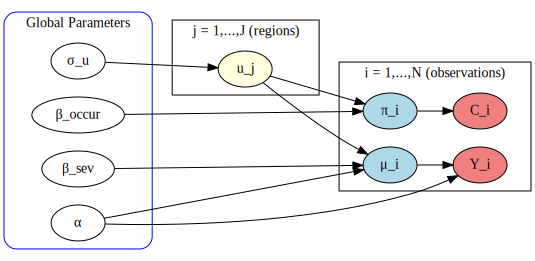

In [59]:
def create_plate_notation_dag():
    """
    Plate notation version showing i (observations) nested in j (regions).
    """
    dot = graphviz.Digraph(comment='Hierarchical Hurdle Model - Plate Notation')
    dot.attr(rankdir='LR')  # Left to right
    
    # Global parameters
    with dot.subgraph(name='cluster_global') as c:
        c.attr(label='Global Parameters', style='rounded', color='blue')
        c.node('sigma_u', 'σ_u')
        c.node('beta_occur', 'β_occur')
        c.node('beta_sev', 'β_sev')
        c.node('alpha', 'α')
    
    # Region level (plate J)
    with dot.subgraph(name='cluster_regions') as c:
        c.attr(label='j = 1,...,J (regions)', style='solid', color='black')
        c.node('u_j', 'u_j', shape='ellipse', fillcolor='lightyellow', style='filled')
    
    # Observation level (plate N)
    with dot.subgraph(name='cluster_obs') as c:
        c.attr(label='i = 1,...,N (observations)', style='solid', color='black')
        
        # Occurrence
        c.node('pi_i', 'π_i', shape='ellipse', fillcolor='lightblue', style='filled')
        c.node('C_i', 'C_i', shape='ellipse', fillcolor='lightcoral', style='filled')
        
        # Severity
        c.node('mu_i', 'μ_i', shape='ellipse', fillcolor='lightblue', style='filled')
        c.node('Y_i', 'Y_i', shape='ellipse', fillcolor='lightcoral', style='filled')
    
    # Edges
    dot.edge('sigma_u', 'u_j')
    dot.edge('beta_occur', 'pi_i')
    dot.edge('u_j', 'pi_i')
    dot.edge('pi_i', 'C_i')
    
    dot.edge('beta_sev', 'mu_i')
    dot.edge('alpha', 'mu_i')
    dot.edge('u_j', 'mu_i')
    dot.edge('mu_i', 'Y_i')
    dot.edge('alpha', 'Y_i')
    
    return dot

# Uncomment to create plate notation version:
dag_plate = create_plate_notation_dag()
# dag_plate.render('/mnt/user-data/outputs/hierarchical_hurdle_dag_plates', format='png', cleanup=True)
dag_plate

In [14]:
np.random.seed(906)
n = 1000
J = 10  # Number of regions

# Assign each observation to a region
region_id = np.random.choice(J, size=n)

# Covariates
X_occur = np.column_stack([
    np.ones(n),
    np.random.normal(0, 1, n),      # Continuous covariate
    np.random.binomial(1, 0.3, n),  # Binary covariate (high risk indicator)
])

X_sev = np.column_stack([
    np.ones(n),
    np.random.uniform(50, 150, n),
    np.random.gamma(2, 1, n)
])

# True parameters
beta_occur_true = np.array([-1.0, 0.5, 0.8])
beta_sev_true = np.array([2.0, 0.01, 0.3])
alpha_true = 4.0

# Region-level random effects (shared across occurrence and severity models)
sigma_u_true = 0.5 # standard deviation of random effects
u_true = np.random.normal(0, sigma_u_true, J)

# Generate occurrence (with region random effects)
logit_pi = X_occur @ beta_occur_true + u_true[region_id]
pi = 1 / (1 + np.exp(-logit_pi))
claim_indicator = np.random.binomial(1, pi, n)

# Generate severity (with region random effects)
log_mu_sev = X_sev @ beta_sev_true + u_true[region_id]
mu_sev = np.exp(log_mu_sev)
beta_gamma = alpha_true / mu_sev
Y_positive = np.random.gamma(alpha_true, 1 / beta_gamma[claim_indicator == 1])

Y_obs = np.zeros(n)
Y_obs[claim_indicator == 1] = Y_positive

print(f"Number of claims: {claim_indicator.sum()}")
print(f"Claim rate: {claim_indicator.mean():.3f}")
print(f"Mean claim amount (given claim): {Y_positive.mean():.2f}")

Number of claims: 310
Claim rate: 0.310
Mean claim amount (given claim): 46.62


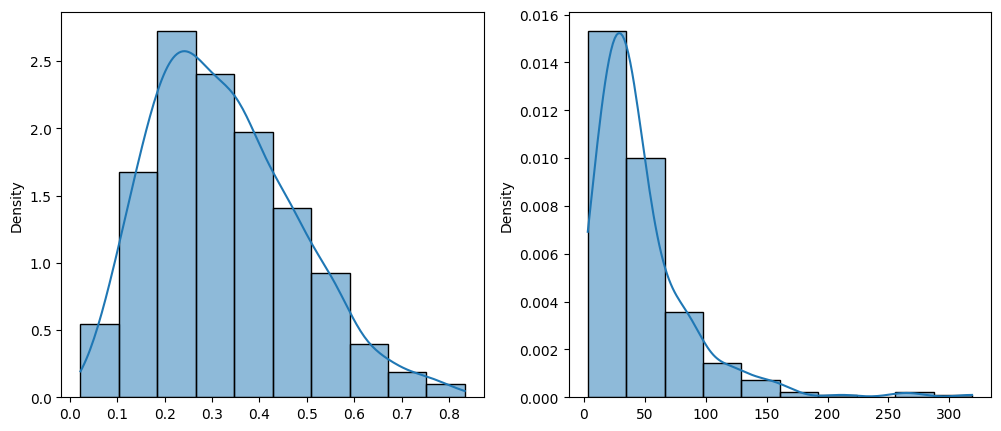

In [12]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(pi, bins=10, stat='density', kde=True, ax=ax[0])
sns.histplot(Y_positive, bins=10, stat='density', kde=True, ax=ax[1]);

In [ ]:
def build_hierarchical_hurdle_gamma(X_occ, X_sev, Y_obs, claim_ind, region_id, n_regions):
    """
    Hierarchical Bayesian Hurdle Gamma Model with shared random effects.

    Parameters:
    -----------
    X_occ : array (n, p1)
        Covariates for the occurrence model.
    X_sev : array (n, p2)
        Covariates for the severity model.
    Y_obs : array (n,)
        Observed response variable (claim amounts 0 for no claims, >0 for claim).
    claim_ind : array (n,)
        Indicator array where 1 indicates a claim occurred, 0 otherwise.
    region_id : array (n,)
        Array indicating the region for each observation (0 to J-1).
    n_regions : int
        Number of regions (J).
    
    Returns:
    -----------
    model : pm.Model
        The constructed PyMC hierarchical model.
    """

    n = len(Y_obs)
    p1 = X_occ.shape[1]
    p2 = X_sev.shape[1]

    # Separate positive observations
    mask_positive = claim_ind == 1
    Y_positive = Y_obs[mask_positive]
    X_sev_positive = X_sev[mask_positive]
    region_id_positive = region_id[mask_positive]

    with pm.Model() as model:
        # ==========================================
        # HIERARCHICAL STRUCTURE
        # ==========================================

        # Hyperprior: standard deviation of random effects
        sigma_u = pm.HalfNormal("sigma_u", sigma=1)

        # Region-level random effects
        u_raw = pm.Normal("u_raw", mu=0, sigma=1, shape=n_regions)

        # Reparametrization
        u = pm.Deterministic("u", u_raw * sigma_u)
        
        # ==========================================
        # OCCURRENCE MODEL
        # ==========================================
        beta_occur = pm.Normal("beta_occur", mu=0, sigma=1.5, shape=p1)

        # Linear predictor with shared random effect
        logit_pi = pm.Deterministic('logit_pi', pm.math.dot(X_occ, beta_occur) + u[region_id])
        pi = pm.Deterministic('pi', pm.math.sigmoid(logit_pi))

        # Likelihood for occurrence
        claim = pm.Bernoulli("claim", p=pi, observed=claim_ind)

        # ==========================================
        # SEVERITY MODEL
        # ==========================================
        beta_sev = pm.Normal("beta_sev", mu=0, sigma=1, shape=p2)
        alpha = pm.HalfNormal("alpha", sigma=5)

        # Linear predictor for severity with shared random effect
        log_mu_sev = pm.math.dot(X_sev_positive, beta_sev) + u[region_id_positive]
        mu_sev = pm.Deterministic("mu_sev", pm.math.exp(log_mu_sev))

        # Gamma likelihood
        beta_gamma = alpha / mu_sev
        Y_severity = pm.Gamma("Y_severity", alpha=alpha, beta=beta_gamma, observed=Y_positive)

        # ==========================================
        # POSTERIOR PREDICTIVE QUANTITIES
        # ==========================================

        # Marginal mean for all observations
        # E[Y] = P(claim) × E[Y | claim]
        # (unconditional mean or expected loss)
        mu_marginal = pm.Deterministic("mu_marginal", pi * pm.math.exp(pm.math.dot(X_sev, beta_sev) + u[region_id]))
        cv_severity = pm.Deterministic("cv_severity", 1.0 / pm.math.sqrt(alpha))
    return model


**Two-Level Prior**

```python
sigma_u = pm.HalfNormal("sigma_u", sigma=1)
u = pm.Normal("u", mu=0, sigma=sigma_u, shape=n_regions)
```

**multilevel prior**

1. **hyperparameter** `sigma_u`

- Controls how much regions vary from each other
- Half-Normal prior ensures positivity, (0, 1) we expect moderate between-region variation
- `sigma_u ≈ 0` → All regions are very similar (little heterogeneity)
- `sigma_u ≈ 1` → Regions differ substantially
- `sigma_u → ∞` → Each region is completely different (no pooling)

2. **random effects** `u`
- Captures region-specific deviations from the "average" effect
- Prior for each region's effect is Normal(0, sigma_u) `u[j] ~ Normal(0, sigma_u)`
- `u[j] = 0` → Region $j$ is "average"
- `u[j] > 0` → Region $j$ has higher occurrence **probability** AND higher **severity**
- `u[j] < 0` → Region $j$ has lower occurrence **probability** AND lower **severity**
- `shape=n_regions` creates a separate random effect for each region

**Why this structure?**

_This_ is **partial pooling**.

$\begin{aligned} \sigma_u & \sim \operatorname{Half-Normal}(0,1) \quad \text { (hyperparameter) } \\ u_j & \sim \operatorname{Normal}\left(0, \sigma_u\right) \quad \text { for } j=1, \ldots, J \quad \text { (random effects) } \\ \operatorname{logit}\left(\pi_i\right) & =\mathbf{X}_{\text {occur }, i}^T \boldsymbol{\beta}_{\text {occur }}+u_{j[i]} \\ \log \left(\mu_i\right) & =\mathbf{X}_{\text {sev }, i}^T \boldsymbol{\beta}_{\text {sev }}+u_{j[i]}\end{aligned}$

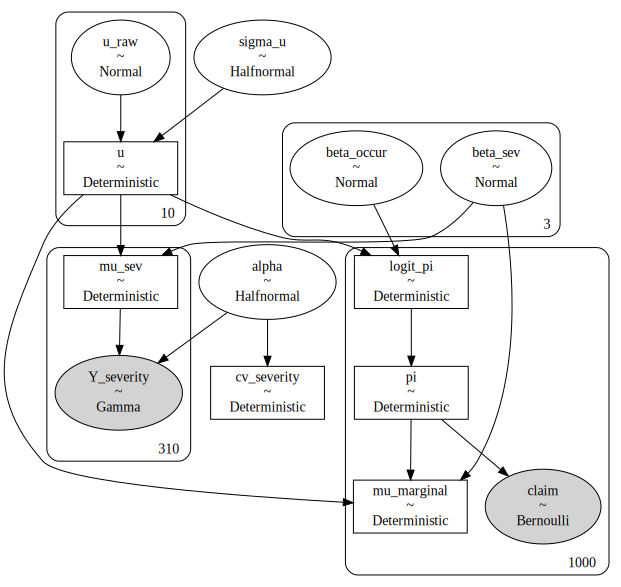

In [18]:
hierarchical_model = build_hierarchical_hurdle_gamma(
    X_occur, X_sev, Y_obs, claim_indicator, region_id, n_regions=J)

pm.model_to_graphviz(hierarchical_model)

**What makes this joint?**

The **random effects** `u` appear in both likelihood components:

$$
\begin{equation}
\begin{aligned}
\operatorname{logit}\left(\pi_i\right) & =\mathbf{X}_{\mathrm{occur}, i}^T \boldsymbol{\beta}_{\mathrm{occur}}+u_{j[i]} \\
\log \left(\mu_i\right) & =\mathbf{X}_{\mathrm{sev}, i}^T \boldsymbol{\beta}_{\mathrm{sev}}+u_{j[i]}
\end{aligned}
\end{equation}
$$

So the **posterior** no longer factorizes.

$$
\mathbb{P}\left(\boldsymbol{\beta}_{\text{occur}}, \boldsymbol{\gamma}_{\text{sev}}, \mathbf{u}, \alpha, \sigma_u \mid \text {data}\right)
$$

In [19]:
with hierarchical_model:
    trace = pm.sample(2000, tune=1000, random_seed=42, target_accept=0.95)
    
# Check convergence
print(pm.summary(trace, var_names=['beta_occur', 'beta_sev', 'alpha', 'sigma_u']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_u, u_raw, beta_occur, beta_sev, alpha]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_occur[0] -1.133  0.190  -1.486   -0.763      0.005    0.003    1644.0   
beta_occur[1]  0.385  0.075   0.237    0.521      0.001    0.001    6586.0   
beta_occur[2]  0.774  0.151   0.486    1.057      0.002    0.002    7503.0   
beta_sev[0]    1.965  0.202   1.572    2.341      0.005    0.003    1724.0   
beta_sev[1]    0.010  0.001   0.008    0.012      0.000    0.000    5739.0   
beta_sev[2]    0.265  0.020   0.229    0.305      0.000    0.000    7273.0   
alpha          4.148  0.325   3.537    4.752      0.004    0.004    7414.0   
sigma_u        0.534  0.150   0.297    0.802      0.004    0.004    1661.0   

               ess_tail  r_hat  
beta_occur[0]    2745.0    1.0  
beta_occur[1]    5065.0    1.0  
beta_occur[2]    5557.0    1.0  
beta_sev[0]      2921.0    1.0  
beta_sev[1]      4924.0    1.0  
beta_sev[2]      5329.0    1.0  
alpha            5755.0    1.0  
sigma_u          3067.0    1.0  


In [60]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [22]:
u_posterior = trace.posterior['u']
u_mean = u_posterior.mean(dim=['chain', 'draw']).values
u_hdi = az.hdi(trace, var_names=['u'], hdi_prob=0.95)['u'].values

mu_marginal_posterior = trace.posterior['mu_marginal']

print(f"Region random effects shape: {u_posterior.shape}")
print(f"Region effects (posterior mean): {u_mean}")

Region random effects shape: (4, 2000, 10)
Region effects (posterior mean): [-0.16441071 -0.07346194  0.32881998 -0.14652225 -0.95396352  0.79340413
  0.44347558  0.23276879  0.00518949 -0.04087264]


In [63]:
# Extract mu_marginal posterior (shape: chains, draws, n_observations)
mu_marginal_samples = trace.posterior['mu_marginal'].values  # (chains, draws, n)

# Reshape to (n_samples, n_observations)
n_samples = mu_marginal_samples.shape[0] * mu_marginal_samples.shape[1]
mu_marginal_flat = mu_marginal_samples.reshape(n_samples, -1)

# Calculate region-specific marginal means for each posterior sample
region_marginal_posteriors = np.zeros((n_samples, J))

for j in range(J):
    mask_region = region_id == j
    if mask_region.sum() > 0:
        # Average across observations in region j for each posterior sample
        region_marginal_posteriors[:, j] = mu_marginal_flat[:, mask_region].mean(axis=1)

# Calculate posterior statistics for each region
region_means = region_marginal_posteriors.mean(axis=0)
region_hdi = np.percentile(region_marginal_posteriors, [2.5, 97.5], axis=0)

# Population-level marginal mean (average across all observations)
population_marginal_mean = mu_marginal_flat.mean(axis=1)
pop_mean = population_marginal_mean.mean()
pop_hdi = np.percentile(population_marginal_mean, [2.5, 97.5])

print(f"Population marginal mean: {pop_mean:.2f} [95% HDI: {pop_hdi[0]:.2f}, {pop_hdi[1]:.2f}]")
print(f"\nRegion marginal means:")
for j in range(J):
    print(f"  Region {j}: {region_means[j]:.2f} [95% HDI: {region_hdi[0, j]:.2f}, {region_hdi[1, j]:.2f}]")


Population marginal mean: 15.37 [95% HDI: 13.70, 17.19]

Region marginal means:
  Region 0: 9.14 [95% HDI: 6.78, 12.10]
  Region 1: 11.17 [95% HDI: 8.42, 14.49]
  Region 2: 16.43 [95% HDI: 12.16, 21.74]
  Region 3: 8.88 [95% HDI: 6.53, 11.83]
  Region 4: 2.14 [95% HDI: 1.39, 3.14]
  Region 5: 40.72 [95% HDI: 33.17, 49.63]
  Region 6: 24.27 [95% HDI: 18.49, 31.55]
  Region 7: 17.38 [95% HDI: 13.54, 22.05]
  Region 8: 11.38 [95% HDI: 8.36, 15.19]
  Region 9: 12.41 [95% HDI: 8.98, 16.68]


In [67]:
loss_exp = trace.posterior['mu_marginal'].mean(dim=['chain', 'draw']).values

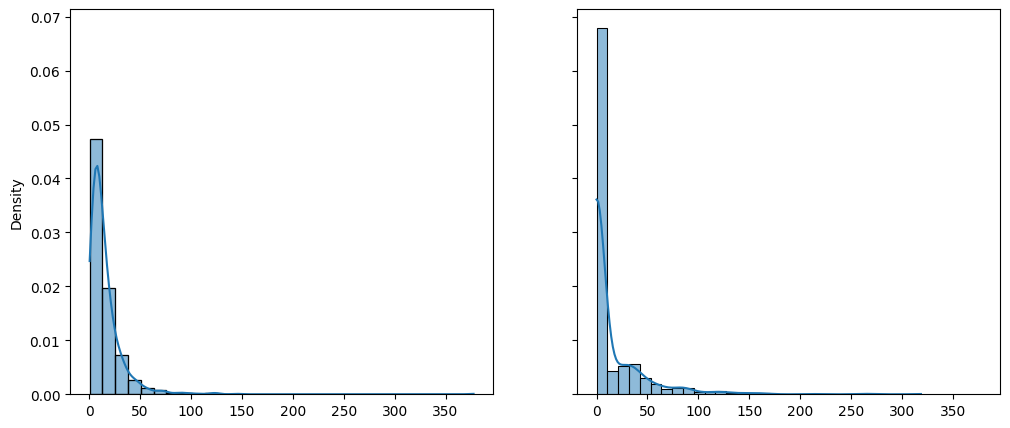

In [72]:
f, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
sns.histplot(loss_exp, stat="density", bins=30, kde=True, ax=ax[0])
sns.histplot(Y_obs, bins=30, stat='density', kde=True, ax=ax[1]);

In [73]:
loss_exp.mean()

np.float64(15.374609378981095)

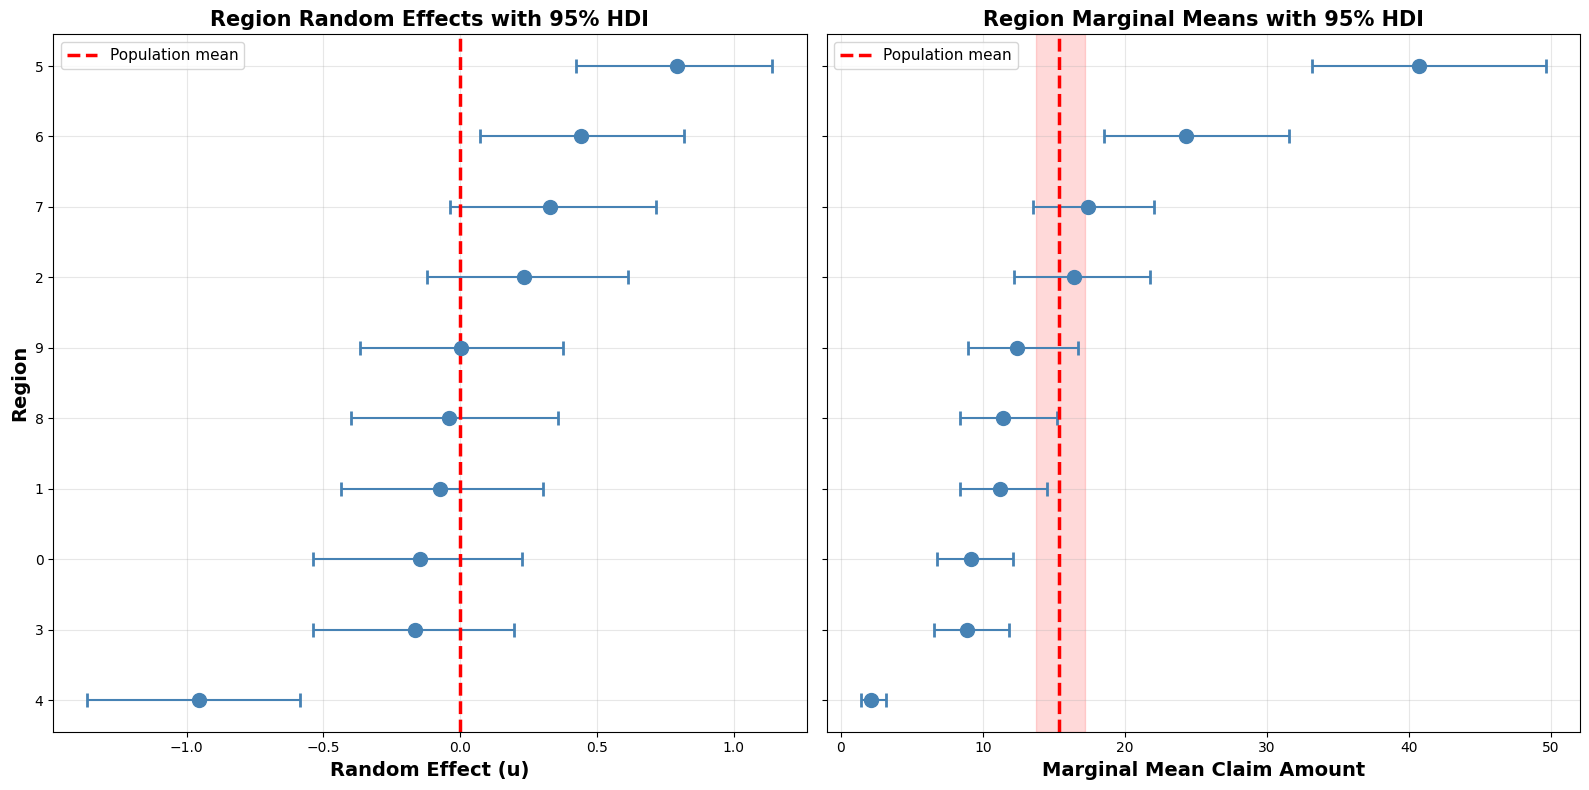

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)   

# ============================================
# LEFT: Random effects
# ============================================
ax = axes[0]
u_posterior = trace.posterior['u']
u_mean = u_posterior.mean(dim=['chain', 'draw']).values
u_hdi = az.hdi(trace, var_names=['u'], hdi_prob=0.95)['u'].values

sorted_idx_u = np.argsort(u_mean)
regions_plot = np.arange(J)

ax.errorbar(u_mean[sorted_idx_u], regions_plot,
            xerr=[u_mean[sorted_idx_u] - u_hdi[sorted_idx_u, 0],
                  u_hdi[sorted_idx_u, 1] - u_mean[sorted_idx_u]],
            fmt='o', markersize=10, capsize=5, capthick=2,
            color='steelblue', ecolor='steelblue')
ax.axvline(0, color='red', linestyle='--', linewidth=2.5, label='Population mean')
ax.set_xlabel('Random Effect (u)', fontsize=14, fontweight='bold')
ax.set_ylabel('Region', fontsize=14, fontweight='bold')
ax.set_yticks(regions_plot)
ax.set_yticklabels([f'{sorted_idx_u[i]}' for i in range(J)])
ax.set_title('Region Random Effects with 95% HDI', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# ============================================
# RIGHT: Marginal means
# ============================================
ax = axes[1]

sorted_idx_means = np.argsort(region_means)

ax.errorbar(region_means[sorted_idx_means], regions_plot,
            xerr=[region_means[sorted_idx_means] - region_hdi[0, sorted_idx_means],
                  region_hdi[1, sorted_idx_means] - region_means[sorted_idx_means]],
            fmt='o', markersize=10, capsize=5, capthick=2,
            color='steelblue', ecolor='steelblue')
ax.axvline(pop_mean, color='red', linestyle='--', linewidth=2.5, 
           label=f'Population mean')
ax.axvspan(pop_hdi[0], pop_hdi[1], alpha=0.15, color='red')
ax.set_xlabel('Marginal Mean Claim Amount', fontsize=14, fontweight='bold')
ax.set_yticks(regions_plot)
ax.set_yticklabels([f'{sorted_idx_means[i]}' for i in range(J)])
ax.set_title('Region Marginal Means with 95% HDI', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Random Intercepts + Random Slopes

For example:

$$
\operatorname{logit}\left(\pi_{i j}\right)=\left(\beta_0+u_{0 j}\right)+\left(\beta_1+u_{1 j}\right) X_{1 i j}+\left(\beta_2+u_{2 j}\right) X_{2 i j}
$$

Both intercepts and slopes vary by region `j`, allowing for more flexible modeling of heterogeneity across regions.

**Non-centered Parameterization** with correlated random effects.

We want **region-specific coefficients** where:
- Each region has its own intercept AND slopes
- These can be correlated (e.g., regions with high intercepts might also have steeper slopes)
- Each coefficient has its own **scale** (variance)

For region $j$:

$$
\mathbf{\beta}_j = \mathbf{\beta}_{\mu} + \mathbf{u}_j
$$

where $\mathbf{u}_j \sim \operatorname{MultiNormal}(\mathbf{0}, \Sigma)$

$$
\boldsymbol{\Sigma}=\left[\begin{array}{ccc}
\sigma_0^2 & \rho_{01} \sigma_0 \sigma_1 & \rho_{02} \sigma_0 \sigma_2 \\
\rho_{01} \sigma_0 \sigma_1 & \sigma_1^2 & \rho_{12} \sigma_1 \sigma_2 \\
\rho_{02} \sigma_0 \sigma_2 & \rho_{12} \sigma_1 \sigma_2 & \sigma_2^2
\end{array}\right]
$$

`LKJCholeskyCov` returns:
- A Cholesky decomposition of the _correlation matrix_ (NOT covariance) `chol_occur`
- Correlation matrix (diagonal = 1) `corr_occur`

The correlation matrix R here is:

$$
\mathbf{R}=\left[\begin{array}{ccc}
1 & \rho_{01} & \rho_{02} \\
\rho_{01} & 1 & \rho_{12} \\
\rho_{02} & \rho_{12} & 1
\end{array}\right]
$$

Why separate scale and correlation?  Makes MCMC sampling more efficient and stable.

Why correlate intercepts and slopes?  It can be a realistic assumption in many contexts.
- Some regions may be "inherently riskier"
- High risk regions (high intercept) might also be more sensitive to certain predictors (steeper slopes)
- If we don't model this correlation, we might misestimate uncertainty or bias estimates.

After all steps, the actual covariance structure is:

$$
\text{Cov}(\mathbf{u}_j) = \text{diag}(\boldsymbol{\sigma}) \cdot \mathbf{R} \cdot \text{diag}(\boldsymbol{\sigma})
$$

Where:
- $\text{diag}(\boldsymbol{\sigma})$ scales the correlation
- $\mathbf{R}$ provides the correlation structure

**This equals:**
$$
\boldsymbol{\Sigma} = \begin{bmatrix}
\sigma_0^2 & \rho_{01}\sigma_0\sigma_1 & \cdots \\
\rho_{01}\sigma_0\sigma_1 & \sigma_1^2 & \cdots \\
\vdots & \vdots & \ddots
\end{bmatrix}
$$

**Summary of the Flow**

1. `beta_mu`:       Population average coefficients
1. `sigma`:         How much each coefficient varies (scale)
1. `chol`/`corr`:   HOW coefficients co-vary (correlation)
1. `z`:             Standardized correlated draws (variance=1, correlated)
1. `u = z * σ`:     Scaled random effects (proper variance, still correlated)
1. `beta_j`:        Region-specific coefficients = beta_mu + u_j


In [82]:
# Correlation matrix (from standardized z)
R = np.array([
    [1.0,  0.6,  0.3],
    [0.6,  1.0,  0.2],
    [0.3,  0.2,  1.0]
])

# Standard deviations
sigma = np.array([0.5, 0.2, 0.3])

# Build covariance matrix: Σ = diag(σ) * R * diag(σ)
D = np.diag(sigma)
Sigma = D @ R @ D

print("Correlation Matrix R:")
print(R)
print("\nStandard Deviations σ:")
print(sigma)
print("\nCovariance Matrix Σ = diag(σ) * R * diag(σ):")
print(Sigma)
print("\n" + "="*60)
print("Verify diagonal elements (variances):")
print(f"Σ[0,0] = {Sigma[0,0]:.4f} = σ₀² = {sigma[0]**2:.4f} ✓")
print(f"Σ[1,1] = {Sigma[1,1]:.4f} = σ₁² = {sigma[1]**2:.4f} ✓")
print(f"Σ[2,2] = {Sigma[2,2]:.4f} = σ₂² = {sigma[2]**2:.4f} ✓")
print("\nVerify off-diagonal elements (covariances):")
print(f"Σ[0,1] = {Sigma[0,1]:.4f} = σ₀·σ₁·ρ₀₁ = {sigma[0]*sigma[1]*R[0,1]:.4f} ✓")
print(f"Σ[0,2] = {Sigma[0,2]:.4f} = σ₀·σ₂·ρ₀₂ = {sigma[0]*sigma[2]*R[0,2]:.4f} ✓")
print(f"Σ[1,2] = {Sigma[1,2]:.4f} = σ₁·σ₂·ρ₁₂ = {sigma[1]*sigma[2]*R[1,2]:.4f} ✓")

Correlation Matrix R:
[[1.  0.6 0.3]
 [0.6 1.  0.2]
 [0.3 0.2 1. ]]

Standard Deviations σ:
[0.5 0.2 0.3]

Covariance Matrix Σ = diag(σ) * R * diag(σ):
[[0.25  0.06  0.045]
 [0.06  0.04  0.012]
 [0.045 0.012 0.09 ]]

Verify diagonal elements (variances):
Σ[0,0] = 0.2500 = σ₀² = 0.2500 ✓
Σ[1,1] = 0.0400 = σ₁² = 0.0400 ✓
Σ[2,2] = 0.0900 = σ₂² = 0.0900 ✓

Verify off-diagonal elements (covariances):
Σ[0,1] = 0.0600 = σ₀·σ₁·ρ₀₁ = 0.0600 ✓
Σ[0,2] = 0.0450 = σ₀·σ₂·ρ₀₂ = 0.0450 ✓
Σ[1,2] = 0.0120 = σ₁·σ₂·ρ₁₂ = 0.0120 ✓


In [90]:
def build_random_slopes_hurdle(
        X_occurrence,
        X_severity,
        Y_obs,
        claim_indicator,
        region_id,
        n_regions,
        var_occ_slopes=True, vary_sev_slopes=True):
    """
    Hierarchical Hurdle-Gamma Model with Random Intercepts and Optional Random Slopes.

    Parameters:
    -----------
    var_occ_slopes : bool
        If True, include random slopes in the occurrence model.
    vary_sev_slopes : bool
        If True, include random slopes in the severity model.
    """

    n = len(Y_obs)
    p1 = X_occurrence.shape[1]
    p2 = X_severity.shape[1]

    mask_positive = claim_indicator == 1
    Y_positive = Y_obs[mask_positive]
    X_sev_positive = X_severity[mask_positive]
    region_id_positive = region_id[mask_positive]

    with pm.Model() as model:
        # ==========================================
        # OCCURRENCE MODEL with RANDOM SLOPES
        # ==========================================

        # Population (Fixed) effects
        # "average" coefficients across all regions (population mean)
        # average effect before accounting for region-specific deviations
        beta_occur_mu = pm.Normal('beta_occur_mu', mu=0, sigma=1.5, shape=p1)

        if var_occ_slopes:
            # standard deviations for each coefficient (how much they vary by region)
            # How much EACH coefficient varies across regions - different coefficients can vary differently across regions
            # sigma_occur[0] = SD of random intercepts
            # sigma_occur[k] = SD of random slopes for covariate k
            sigma_occur = pm.HalfNormal('sigma_occur', sigma=1, shape=p1)

            # Correlation matrix for random effects
            # Correlate random intercepts and slopes
            chol_occur, corr_occur, _ = pm.LKJCholeskyCov(
                'chol_occur',
                n=p1,
                eta=2,  # Weakly informative
                sd_dist=pm.Exponential.dist(1.0),
                compute_corr=True
            )

            # Random effects: (n_regions, p1)
            # "Standardized" random effects on the correlation scale.  Each element has variance 1 (standardized) but now correlated.
            # $z_j ~ MVN(0, R)$
            # z_occur[:, 0] = random intercepts
            # z_occur[:, k] = random slopes for covariate k
            z_occur = pm.MvNormal('z_occur', mu=0, chol=chol_occur, shape=(n_regions, p1))

            # z_occur.shape = (n_regions, p1)
            # z_occur[j, k] = standardized random effect for region j, coefficient k
            # each row is one 3-dimensional draw from MVN(0, R)
            # WITHIN each correlation, the 3 elements are correlated according to chol_occur
            # BETWEEN rows, the draws are independent Cov(z_occur[j, :], z_occur[j', :]) = 0 for j != j'
            # Region 0's deviations don't tell us anything about Region 1's deviations, etc.
            # Each region gets its own independent draw from the multivariate normal

            # Actual random effects (scaled by sigma)
            # We need to multiply element-wise to give proper variance to each coefficient
            # $\mathbf{u}_j=\mathbf{z}_j \odot \boldsymbol{\sigma}$
            u_occur = pm.Deterministic('u_occur', z_occur * sigma_occur)

            # Region-specific coefficients: beta_j = beta_mu + u_j
            beta_occur_region = pm.Deterministic('beta_occur_region', beta_occur_mu + u_occur)

            # Linear predictor: differering coefficients for each region
            # We need to select the appropriate beta for each observation
            logit_pi = pm.Deterministic('logit_pi', pm.math.sum(X_occurrence * beta_occur_region[region_id, :], axis=1))
        else:
            # Random intercepts only
            sigma_u_occ = pm.HalfNormal('sigma_u_occ', sigma=1)
            u_occ = pm.Normal('u_occ', mu=0, sigma=sigma_u_occ, shape=n_regions)

            logit_pi = pm.Deterministic('logit_pi', pm.math.dot(X_occurrence, beta_occur_mu) + u_occ[region_id])

        pi = pm.Deterministic('pi', pm.math.sigmoid(logit_pi))
        pm.Bernoulli('claim', p=pi, observed=claim_indicator)

        # ==========================================
        # SEVERITY MODEL with RANDOM SLOPES
        # ==========================================

        # Population (Fixed) effects
        beta_sev_mu = pm.Normal('beta_sev_mu', mu=0, sigma=1, shape=p2)
        alpha = pm.HalfNormal('alpha', sigma=5)

        if vary_sev_slopes:
            sigma_sev = pm.HalfNormal('sigma_sev', sigma=1, shape=p2)

            chol_sev, corr_sev, _ = pm.LKJCholeskyCov(
                'chol_sev',
                n=p2,
                eta=2,
                sd_dist=pm.Exponential.dist(1.0),
                compute_corr=True
            )

            # Random effects for severity: (n_regions, p2)
            z_sev = pm.MvNormal('z_sev', mu=0, chol=chol_sev, shape=(n_regions, p2))

            u_sev = pm.Deterministic('u_sev', z_sev * sigma_sev)

            # Region-specific coefficients for severity for each region
            beta_sev_region = pm.Deterministic('beta_sev_region', beta_sev_mu + u_sev)

            # Linear predictors only for positive claims
            log_mu_sev = pm.Deterministic('log_mu_sev', pm.math.sum(X_sev_positive * beta_sev_region[region_id_positive, :], axis=1))
        else:
            # Random intercepts only
            sigma_u_sev = pm.HalfNormal('sigma_u_sev', sigma=1)
            u_sev = pm.Normal('u_sev', mu=0, sigma=sigma_u_sev, shape=n_regions)

            log_mu_sev = pm.Deterministic('log_mu_sev', pm.math.dot(X_sev_positive, beta_sev_mu) + u_sev[region_id_positive])
        
        mu_sev = pm.Deterministic('mu_sev', pm.math.exp(log_mu_sev))
        beta_gamma = alpha / mu_sev
        pm.Gamma('Y_severity', alpha=alpha, beta=beta_gamma, observed=Y_positive)

        # ==========================================
        # DERIVED QUANTITIES
        # ==========================================
        if vary_sev_slopes:
            mu_marginal_log = pm.math.sum(X_severity * beta_sev_region[region_id, :], axis=1)
        else:
            mu_marginal_log = pm.math.dot(X_severity, beta_sev_mu) + u_sev[region_id]

        mu_marginal = pm.Deterministic('mu_marginal', pi * pm.math.exp(mu_marginal_log))
        cv_severity = pm.Deterministic('cv_severity', 1.0 / pm.math.sqrt(alpha))

    return model


In [91]:
# Correlation matrix example
n_regions = 10
p1 = 3

# Create a correlation matrix
# This is what chol_occur would decompose
np.random.seed(50)
with pm.Model():
    # Create LKJ correlation structure
    chol, corr, _ = pm.LKJCholeskyCov(
        'chol',
        n=p1,
        eta=2,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True
    )

    # Sample z_occur
    z_occur = pm.MvNormal('z_occur', mu=0, chol=chol, shape=(n_regions, p1))

    # sample from prior
    prior = pm.sample_prior_predictive(samples=1, random_seed=50)

# Extract one sample
z_sample = prior.prior['z_occur'].values[0, 0, :, :]  # Shape: (10, 3)
corr_sample = prior.prior['chol_corr'].values[0, 0, :, :]   # Shape: (3, 3)

print("Correlation Matrix (applies to ALL regions):")
print(corr_sample)
print("\n" + "="*60)
print("\nStandardized Random Effects z_occur (shape: 10 regions × 3 coefficients):")
print("="*60)
print(f"{'Region':<10} {'Intercept':<12} {'Covariate1':<12} {'Covariate2':<12}")
print("-"*60)
for j in range(n_regions):
    print(f"{j:<10} {z_sample[j, 0]:>11.3f} {z_sample[j, 1]:>11.3f} {z_sample[j, 2]:>11.3f}")

print("\n" + "="*60)
print("Key Observations:")
print("="*60)
print("1. WITHIN-REGION correlation:")
print(f"   - Region 0: intercept={z_sample[0,0]:.2f}, cov1={z_sample[0,1]:.2f}")
print(f"   - If correlation is positive and intercept is high, cov1 tends to be high too")
print(f"\n2. BETWEEN-REGION independence:")
print(f"   - Region 0: {z_sample[0,:]}")
print(f"   - Region 1: {z_sample[1,:]}")
print(f"   - These are independent draws (knowing Region 0 doesn't tell us about Region 1)")
print(f"\n3. All regions use the SAME correlation structure")
print(f"   - But each gets its own random draw")


Sampling: [chol, z_occur]


Correlation Matrix (applies to ALL regions):
[[ 1.         -0.41081371 -0.59948864]
 [-0.41081371  1.         -0.12059031]
 [-0.59948864 -0.12059031  1.        ]]


Standardized Random Effects z_occur (shape: 10 regions × 3 coefficients):
Region     Intercept    Covariate1   Covariate2  
------------------------------------------------------------
0                1.590       0.018      -2.899
1               -1.387       0.478       0.596
2                0.270      -0.270      -0.594
3                0.895      -0.063      -4.093
4                0.978      -0.427       0.752
5               -1.368      -0.172       2.958
6                3.695       0.133      -3.721
7                0.278      -0.700       2.556
8               -0.494      -0.288       2.312
9                2.544      -0.673      -0.689

Key Observations:
1. WITHIN-REGION correlation:
   - Region 0: intercept=1.59, cov1=0.02
   - If correlation is positive and intercept is high, cov1 tends to be high too

2. BETWE

/tmp/ipykernel_1416804/3621263395.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,


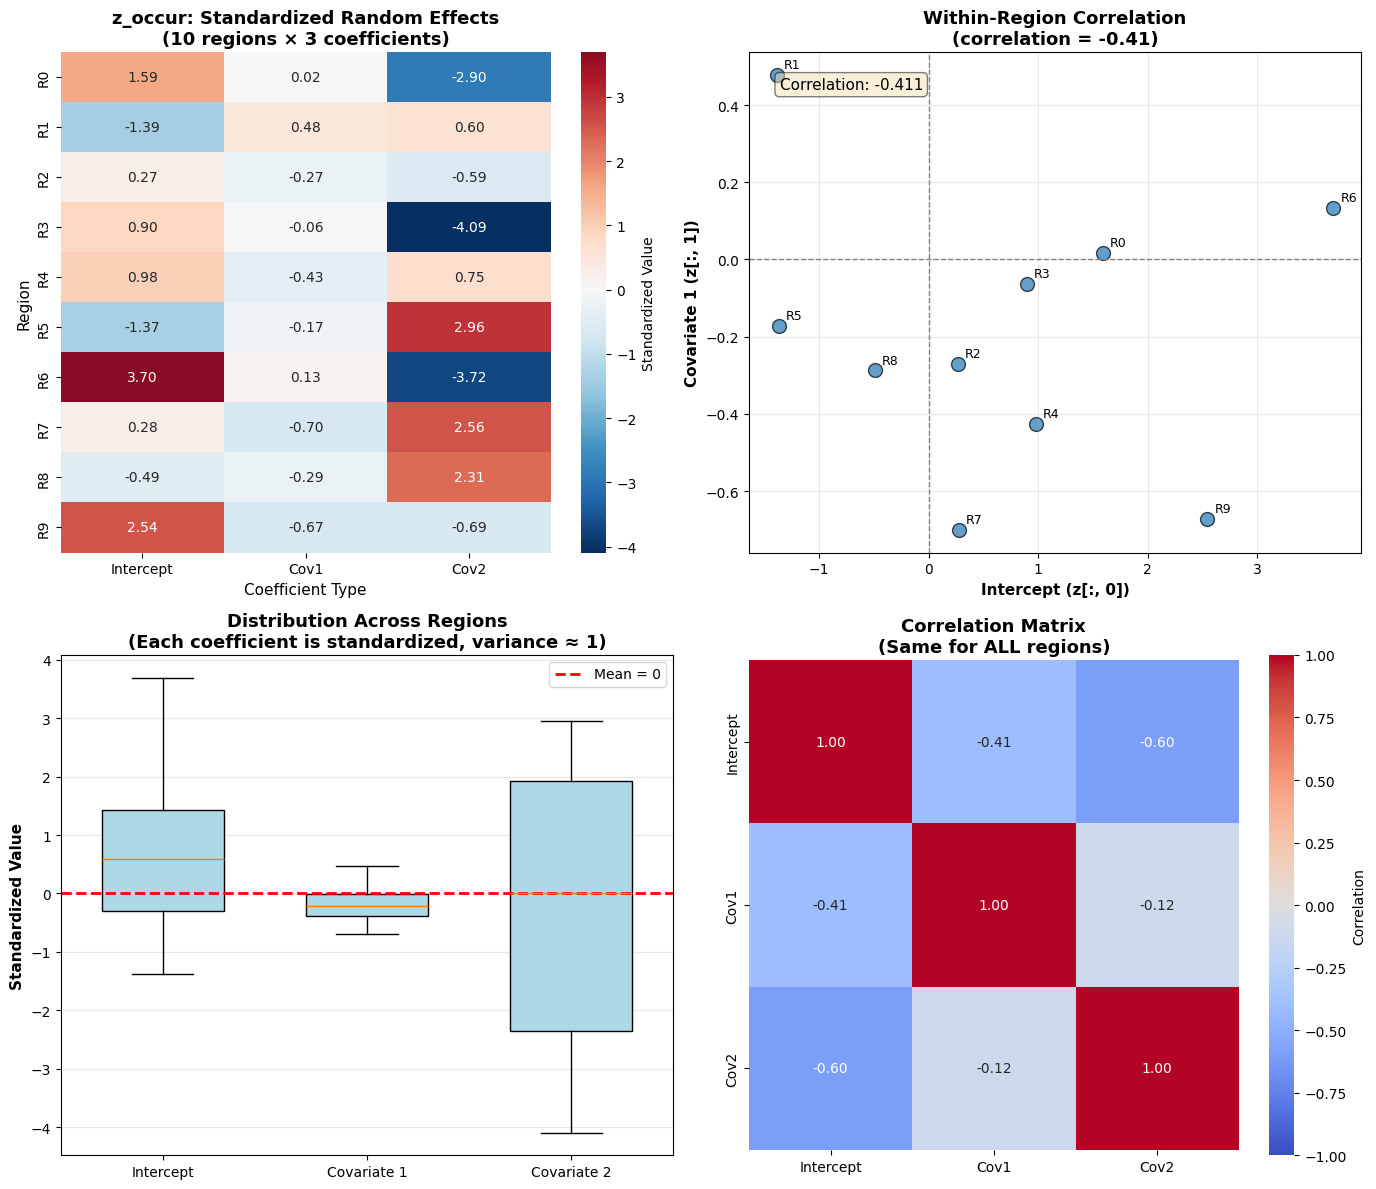

In [79]:
# Extract samples with correct variable names
z_sample = prior.prior['z_occur'].values[0, 0, :, :]  
corr_sample = prior.prior['chol_corr'].values[0, 0, :, :]  # FIXED

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ============================================
# Plot 1: The z_occur matrix as a heatmap
# ============================================
ax = axes[0, 0]
sns.heatmap(z_sample, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            ax=ax, cbar_kws={'label': 'Standardized Value'},
            xticklabels=['Intercept', 'Cov1', 'Cov2'],
            yticklabels=[f'R{i}' for i in range(n_regions)])
ax.set_title('z_occur: Standardized Random Effects\n(10 regions × 3 coefficients)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Coefficient Type', fontsize=11)
ax.set_ylabel('Region', fontsize=11)

# ============================================
# Plot 2: Correlation between intercept and slope1
# ============================================
ax = axes[0, 1]
ax.scatter(z_sample[:, 0], z_sample[:, 1], s=100, alpha=0.7, edgecolors='black')
for j in range(n_regions):
    ax.annotate(f'R{j}', (z_sample[j, 0], z_sample[j, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Intercept (z[:, 0])', fontsize=11, fontweight='bold')
ax.set_ylabel('Covariate 1 (z[:, 1])', fontsize=11, fontweight='bold')
ax.set_title(f'Within-Region Correlation\n(correlation = {corr_sample[0,1]:.2f})', 
             fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# Add correlation info
ax.text(0.05, 0.95, f'Correlation: {corr_sample[0,1]:.3f}', 
        transform=ax.transAxes, fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================
# Plot 3: Distribution of each coefficient across regions
# ============================================
ax = axes[1, 0]
positions = [1, 2, 3]
box_data = [z_sample[:, 0], z_sample[:, 1], z_sample[:, 2]]
bp = ax.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                labels=['Intercept', 'Covariate 1', 'Covariate 2'])
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
ax.set_ylabel('Standardized Value', fontsize=11, fontweight='bold')
ax.set_title('Distribution Across Regions\n(Each coefficient is standardized, variance ≈ 1)', 
             fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.legend()

# ============================================
# Plot 4: Correlation matrix heatmap
# ============================================
ax = axes[1, 1]
sns.heatmap(corr_sample, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, ax=ax, square=True,
            xticklabels=['Intercept', 'Cov1', 'Cov2'],
            yticklabels=['Intercept', 'Cov1', 'Cov2'],
            cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix\n(Same for ALL regions)', 
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

In [81]:
sigma_illustrate = [0.5, 0.2, 0.3]
u_sample = z_sample * sigma_illustrate
u_sample

array([[ 0.79481448,  0.00355364, -0.86964356],
       [-0.69331923,  0.09561673,  0.17866607],
       [ 0.13503661, -0.05402037, -0.17828107],
       [ 0.44760565, -0.01261353, -1.22800937],
       [ 0.48910086, -0.08545391,  0.2256581 ],
       [-0.6837667 , -0.03432429,  0.88744054],
       [ 1.84754007,  0.0266452 , -1.11625532],
       [ 0.13882766, -0.14001153,  0.76675112],
       [-0.24714286, -0.05751305,  0.6937454 ],
       [ 1.27205479, -0.13461795, -0.20667933]])

In [92]:
np.random.seed(9999)
n = 1000
J = 10
region_id = np.random.choice(J, size=n)

# Covariates
X_occur = np.column_stack([
    np.ones(n),
    np.random.normal(0, 1, n),
    np.random.binomial(1, 0.3, n)
])

X_sev = np.column_stack([
    np.ones(n),
    np.random.uniform(50, 150, n),
    np.random.gamma(2, 1, n)
])

# Population-level (fixed) effects
beta_occur_mu_true = np.array([-1.0, 0.5, 0.8])
beta_sev_mu_true = np.array([2.0, 0.01, 0.3])
alpha_true = 4.0

# Random effects standard deviations
sigma_occur_true = np.array([0.5, 0.2, 0.3])
sigma_sev_true = np.array([0.4, 0.005, 0.15])

# Generated correlated random effects
# For simplicity, use independent random effects (but could add correlation structure)
u_occur_true = np.random.normal(0, 1, (J, 3)) * sigma_occur_true # (J, 3)
u_sev_true = np.random.normal(0, 1, (J, 3)) * sigma_sev_true     # (J, 3)

# Region-specific coefficients
beta_occur_region_true = beta_occur_mu_true + u_occur_true  # (J, 3)
beta_sev_region_true = beta_sev_mu_true + u_sev_true        # (J, 3)

# Generate occurrence
logit_pi = np.sum(X_occur * beta_occur_region_true[region_id, :], axis=1)
pi = 1 / (1 + np.exp(-logit_pi))
claim_indicator = np.random.binomial(1, pi, n)

# Generate severity
log_mu_sev = np.sum(X_sev * beta_sev_region_true[region_id, :], axis=1)
mu_sev = np.exp(log_mu_sev)
beta_gamma = alpha_true / mu_sev
Y_positive = np.random.gamma(alpha_true, 1 / beta_gamma[claim_indicator == 1])

Y_obs = np.zeros(n)
Y_obs[claim_indicator == 1] = Y_positive

print(f"Number of claims: {claim_indicator.sum()}")
print(f"Claim rate: {claim_indicator.mean():.3f}")
print(f"\nExample region-specific occurrence coefficients:")
print(beta_occur_region_true[:3, :])

Number of claims: 320
Claim rate: 0.320

Example region-specific occurrence coefficients:
[[-0.97739245  0.93824703  1.04529474]
 [-0.95899933  0.38199753  0.39691732]
 [-0.72359372  0.47393218  1.10057778]]


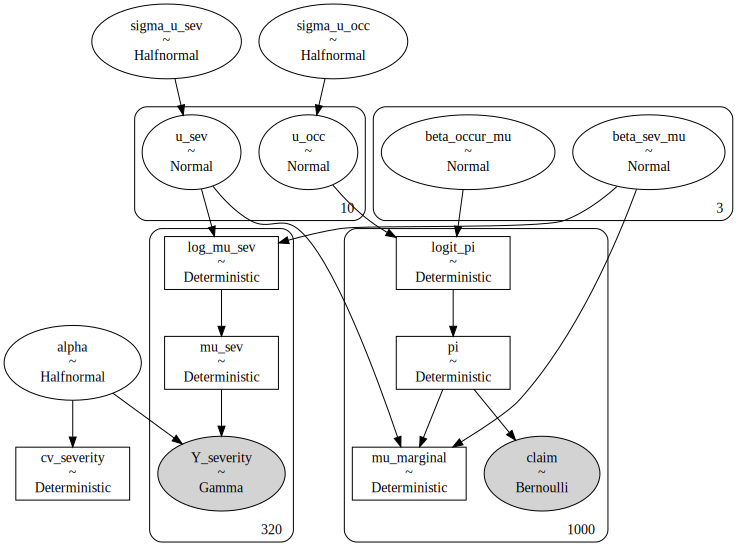

In [96]:
hierarchical_model = build_random_slopes_hurdle(
    X_occur, X_sev, Y_obs, claim_indicator, region_id, n_regions=J, var_occ_slopes=False, vary_sev_slopes=False)

pm.model_to_graphviz(hierarchical_model)

In [97]:
with hierarchical_model:
    trace = pm.sample(2000, tune=1000, random_seed=42, target_accept=0.95)
    
# Check convergence
# All parameters including region-specific effects
var_names_full = [
    # Population-level (fixed) effects
    'beta_occur_mu',
    'beta_sev_mu',
    'alpha',
    
    # Variance components
    'sigma_occur',
    'sigma_sev',
    
    # Correlation structures
    'chol_occur_corr',
    'chol_sev_corr',
    
    # Standardized random effects
    'z_occur',
    'z_sev',
    
    # Scaled random effects (deterministic, but useful)
    'u_occur',
    'u_sev',
    
    # Region-specific coefficients (deterministic)
    'beta_occur_region',
    'beta_sev_region',
]

pm.summary(trace, var_names=var_names_full)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_occur_mu, sigma_u_occ, u_occ, beta_sev_mu, alpha, sigma_u_sev, u_sev]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.


KeyError: 'var names: "[\'sigma_occur\' \'sigma_sev\' \'chol_occur_corr\' \'chol_sev_corr\' \'z_occur\'\\n \'z_sev\' \'u_occur\' \'beta_occur_region\' \'beta_sev_region\'] are not present" in dataset'

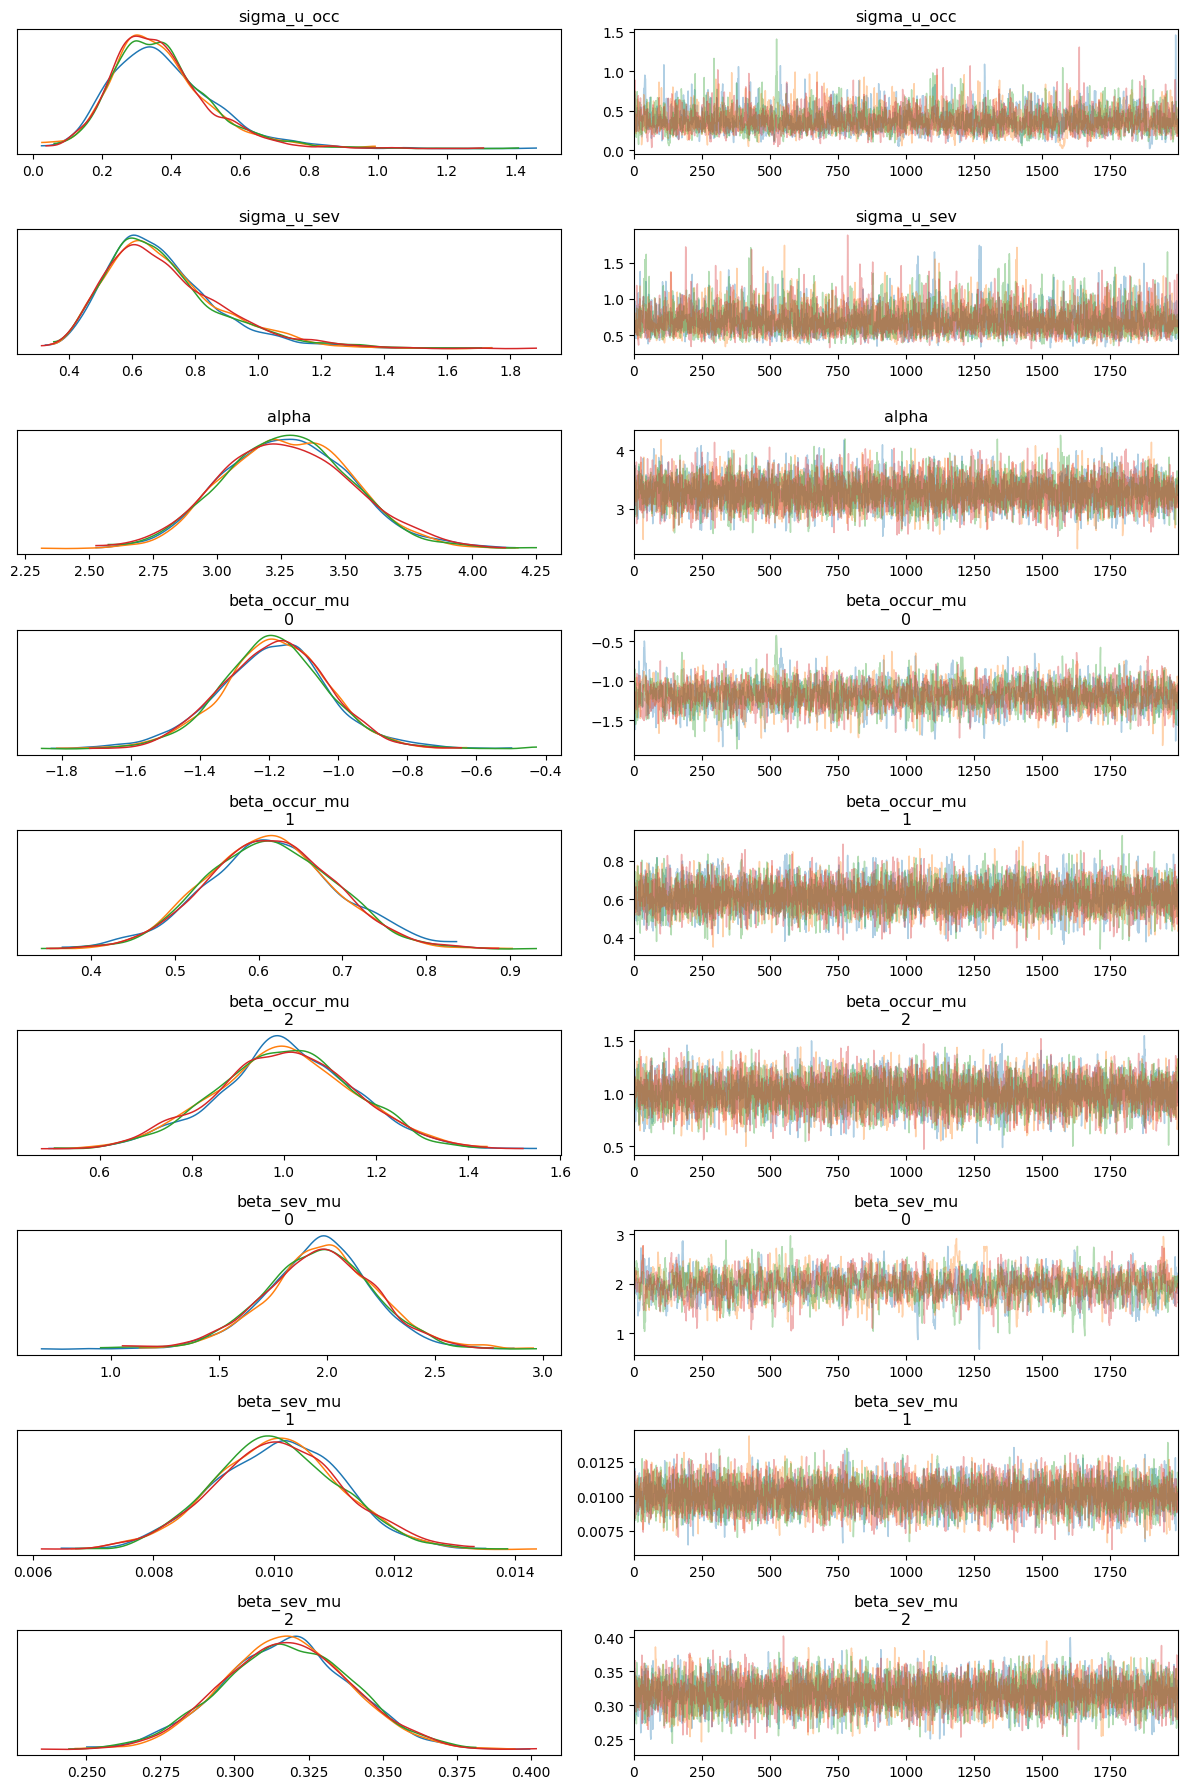

In [103]:
import arviz as az

# Focus on variance parameters (usually the problem)
az.plot_trace(
    trace,
    var_names=['sigma_u_occ', 'sigma_u_sev', 'alpha', 'beta_occur_mu', 'beta_sev_mu'],
    compact=False
)
plt.tight_layout()
plt.show()

## Correlation via Shared Fixed Effects

- Create overlapping covariates in the occurrence and severity models.
- This induces correlation between the two parts of the model through shared fixed effects.
- The is the simplest and most interpretable approach.
- Correlation is deterministic - same covariate always pushes both in the same direction.

In [ ]:
# e.g., "high risk region" indicator appears in both X_occ and X_sev
X_shared = np.random.binomial(1, 0.3, n)

X_occur = np.column_stack([
    np.ones(n),
    X_shared,                       # ← Shared covariate
    np.random.normal(0, 1, n),      # ← Additional continuous covariate
])

X_sev = np.column_stack([
    np.ones(n),
    X_shared,                       # ← Shared covariate
    np.random.uniform(50, 150, n)
])

with pm.Model() as model:
    beta_occur = pm.Normal('beta_occur', mu=0, sigma=1.5, shape=X_occur.shape[1])
    beta_sev = pm.Normal('beta_sev', mu=0, sigma=1.5, shape=X_sev.shape[1])

    # Both models use X_shared through their respective betas
    logit_pi = X_occur @ beta_occur # Includes X_shared * beta_occur[1]
    log_mu = X_sev @ beta_sev       # Includes X_shared * beta_sev[1]

## Correlated Random Effects (Most Flexible)

- Allows stochastic correlation between occurrence and severity components.

$$
\left[\begin{array}{l}
u_{\mathrm{occ}, j} \\
u_{\mathrm{sev}, j}
\end{array}\right] \sim \operatorname{MVN}\left(\left[\begin{array}{l}
0 \\
0
\end{array}\right],\left[\begin{array}{cc}
\sigma_{\mathrm{occ}}^2 & \rho \sigma_{\mathrm{occ}} \sigma_{\mathrm{sev}} \\
\rho \sigma_{\mathrm{occ}} \sigma_{\mathrm{sev}} & \sigma_{\mathrm{sev}}^2
\end{array}\right]\right)
$$

- $\rho \in [-1,1]$ controls **correlation** between occurrence and severity random effects
- $\rho > 0$ → Regions with higher occurrence probability tend to have higher severity
- $\rho < 0$ → Regions with higher occurrence probability tend to have lower severity
- $\rho = 0$ → No correlation between occurrence and severity random effects back to the independent random effects model

In [ ]:
def build_correlated_random_effects_hurdle(
        X_occurrence,
        X_severity,
        Y_obs,
        claim_indicator,
        region_id,
        n_regions):
    """
    Hurdle model with Correlated Random Effects for Occurrence and Severity.

    Key feature: (u_occ_j, u_sev_j) ~ MVN(0, Σ) and correlation rho
    where Σ captures correlation between occurrence and severity random effects.
    """

    n = len(Y_obs)
    p1 = X_occurrence.shape[1]
    p2 = X_severity.shape[1]

    mask_positive = claim_indicator == 1
    Y_positive = Y_obs[mask_positive]
    X_sev_positive = X_severity[mask_positive]
    region_id_positive = region_id[mask_positive]

    with pm.Model() as model:
        # ==========================================
        # CORRELATED RANDOM EFFECTS STRUCTURE
        # ==========================================

        # Standard deviations for each component
        sigma_u = pm.HalfNormal("sigma_u", sigma=1, shape=2)  # ← [σ_occ, σ_sev]

        # Correlation between occurrence and severity random effects
        # LKJ prior for correlation matrix
        chol, corr, stds = pm.LKJCholeskyCov(
            "chol_cov",
            n=2,                                   # Bivariate (occurrence, severity)
            eta=2,
            sd_dist=pm.HalfNormal.dist(sigma=1),
            compute_corr=True
        )

        # Bivariate random effects for each region: shape (n_regions, 2)
        # u[:, 0] = occurrence random effects
        # u[:, 1] = severity random effects
        u = pm.MvNormal('u', mu=0, chol=chol, shape=(n_regions, 2))

        # Extract components
        u_occ = pm.Deterministic('u_occ', u[:, 0])
        u_sev = pm.Deterministic('u_sev', u[:, 1])

        # Extract correlation
        rho = pm.Deterministic('rho', corr[0, 1])

        # ==========================================
        # OCCURRENCE MODEL
        # ==========================================
        beta_occur = pm.Normal('beta_occur', mu=0, sigma=1.5, shape=p1)

        logit_pi = pm.Deterministic('logit_pi', pm.math.dot(X_occurrence, beta_occur) + u_occ[region_id])
        pi = pm.Deterministic('pi', pm.math.sigmoid(logit_pi))

        pm.Bernoulli('claim', p=pi, observed=claim_indicator)

        # ==========================================
        # SEVERITY MODEL
        # ==========================================
        beta_sev = pm.Normal('beta_sev', mu=0, sigma=1, shape=p2)
        alpha = pm.HalfNormal('alpha', sigma=5)

        log_mu_sev = pm.math.dot(X_sev_positive, beta_sev) + u_sev[region_id_positive]
        mu_sev = pm.Deterministic('mu_sev', pm.math.exp(log_mu_sev))

        beta_gamma = alpha / mu_sev
        pm.Gamma('Y_severity', alpha=alpha, beta=beta_gamma, observed=Y_positive)

        # ==========================================
        # DERIVED QUANTITIES
        # ==========================================
        mu_marginal = pm.Deterministic('mu_marginal', pi * pm.math.exp(pm.math.dot(X_severity, beta_sev) + u_sev[region_id]))
        cv_severity = pm.Deterministic('cv_severity', 1.0 / pm.math.sqrt(alpha))

    return model